# Beak Data Challenge - Data Analyst
## Database exploration and analysis

In [3]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text


### Setup the database server
credentials = {
    'host':'35.227.110.100',
    'dbname':'postgres',
    'user':'postgres',
    'password':'n$EYUJRrmZ9jz2>7o',
    'port':'5432'
}

sql_engine = create_engine(f"postgresql://{credentials['user']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['dbname']}")

def runQuery(sql):
    result = sql_engine.connect().execute((text(sql)))
    return pd.DataFrame(result.fetchall(), columns=result.keys())

## 1. Top Ten

### Users

In [4]:
runQuery("""
SELECT user_id, SUM(seconds) as Total_time
FROM audiobook_plays
GROUP BY user_id
ORDER BY Total_time DESC
LIMIT 10;
""")

,user_id,total_time
0,876083,1685061.545
1,954745,1295564.176
2,829232,920223.793
3,53930,901351.575
4,967058,823700.546
5,980108,751762.359
6,844824,670955.438
7,958114,604498.961
8,527831,601459.086
9,910357,594632.452


### Audiobooks

In [5]:
runQuery("""
    SELECT audiobook_id, SUM(seconds) as Total_time
    FROM audiobook_plays
    GROUP BY audiobook_id
    ORDER BY Total_time DESC
    LIMIT 10;
""")

,audiobook_id,total_time
0,308346,5025181.050
1,238952,4092814.217
2,249087,3022995.480
3,223467,2483408.005
4,223494,2465606.344
5,223329,2118576.488
6,105720,2118238.976
7,243851,1745427.782
8,182131,1632881.546
9,202942,1492383.766


## 2. Weakly Unique Active Users

In [6]:
runQuery("""
    WITH WAU (year, weekly, user_id) AS (
        SELECT date_part('year', created_at::date)
        , date_part('week', created_at::date)
        , user_id
        FROM audiobook_plays
    )
    SELECT year
        , weekly
        , COUNT(DISTINCT user_id)
    FROM WAU
    GROUP BY year, weekly
    ORDER BY year, weekly
    LIMIT 50;
""")


,year,weekly,count
0,2018.0,1.0,68
1,2018.0,49.0,11
2,2018.0,50.0,36
3,2018.0,51.0,86
4,2018.0,52.0,161
5,2019.0,1.0,167
6,2019.0,2.0,235
7,2019.0,3.0,544
8,2019.0,4.0,663
9,2019.0,5.0,557


## 3. Week over week retention rate of active users

In [7]:
runQuery("""
    WITH user_week_date(user_id, 
        current_date_, prev_date) AS (
        SELECT DISTINCT
            abp.user_id
            , cw.current_week
            , (cw.current_week - INTERVAL '7 days')::date
        FROM audiobook_plays abp
            , LATERAL(SELECT DISTINCT abp.user_id, DATE_TRUNC('week',created_at)::date AS current_week) cw
        ORDER BY user_id, cw.current_week
    ),
    user_week_active AS (
        SELECT *
            , LAG(current_date_) OVER(PARTITION BY user_id ORDER BY current_date_) AS last_week
        FROM user_week_date uwa
    ),
    user_retention AS (
        SELECT *
            , prev_date=last_week AS retained
        FROM user_week_active
    ),
    week_over_week AS (
        SELECT current_date_
            , COUNT(1) AS total_users
            , COUNT(CASE WHEN retained THEN 1 END) AS active_users
        FROM user_retention
        GROUP BY current_date_
        ORDER BY current_date_
    )
    SELECT current_date_ AS week
        , total_users
        , active_users
        , ROUND(active_users::numeric/total_users*100, 2) AS retention_rate
    FROM week_over_week;
""")

,week,total_users,active_users,retention_rate
0,2018-12-03,11,0,0.00
1,2018-12-10,36,6,16.67
2,2018-12-17,86,13,15.12
3,2018-12-24,161,57,35.40
4,2018-12-31,186,94,50.54
5,2019-01-07,235,83,35.32
6,2019-01-14,544,129,23.71
7,2019-01-21,663,260,39.22
8,2019-01-28,557,290,52.06
9,2019-02-04,454,226,49.78


## 4. Average time listened last 30 days

In [8]:
runQuery("""
    SELECT user_id
        , SUM(seconds/3600) AS hours_played --tener en cuenta que preguntan por horas
        , AVG(seconds/3600) AS mean_hours_played --tener en cuenta que preguntan por horas
    FROM audiobook_plays ap
    INNER JOIN users u 
    ON ap.user_id = u.id
    WHERE ap.created_at > u.last_sign_in_at - INTERVAL '30 days'
    GROUP BY user_id
    ORDER BY user_id;
""")

,user_id,hours_played,mean_hours_played
0,2392,8.576727222222222222224444,0.136138527336860670194039
1,4461,0.05794666666666666666,0.02897333333333333333
2,8427,0.09480194444444444445,0.02370048611111111111
3,9511,2.48346694444444444444,0.14608629084967320261
4,10520,68.554160833333333344513334,0.155099911387631975892564
...,...,...,...
1962,993510,0.51142833333333333332,0.08523805555555555555
1963,993528,1.2491686111111111,1.24916861111111110000
1964,993558,1.05020777777777777778,0.35006925925925925926
1965,993705,0.09918916666666666667,0.09918916666666666667


## 5. Month over month growth audiobook plays (%)

In [9]:
runQuery("""
    SELECT *
        , ROUND((count_by_month- LAG(count_by_month) OVER())::numeric * 100 / LAG(count_by_month) OVER(), 2) AS month_growth
    FROM (
        SELECT DATE_TRUNC('month', created_at) AS months
            , COUNT(1) AS count_by_month
            --, AS number_plays
        FROM audiobook_plays
        GROUP BY DATE_TRUNC('month', created_at)
        ORDER BY months) AS counts;
""")

,months,count_by_month,month_growth
0,2018-12-01,11229,None
1,2019-01-01,32230,187.02
2,2019-02-01,23659,-26.59
3,2019-03-01,29823,26.05
4,2019-04-01,8705,-70.81


### 6. Distribution of users suscribed 

In [14]:
df_suscribed = runQuery("""
    WITH users_suscribed AS (
        SELECT id
        FROM users
        WHERE has_been_subscribed
    ),
    first_time_played(user_id, month_date) AS (
        SELECT DISTINCT ap.user_id
        , DATE_TRUNC('month', FIRST_VALUE(ap.created_at) OVER (PARTITION BY ap.user_id ORDER BY ap.created_at))::date
        FROM audiobook_plays ap
        INNER JOIN users_suscribed us
        ON ap.user_id = us.id
    )
    SELECT CONCAT(DATE_PART('year', month_date), '-',DATE_PART('month', month_date)) AS month_year
    FROM first_time_played
    ;
    """)
df_suscribed.head()

,month_year
0,2018-12
1,2018-12
2,2019-1
3,2019-2
4,2019-2


Text(0.5, 0, 'Year - Month')

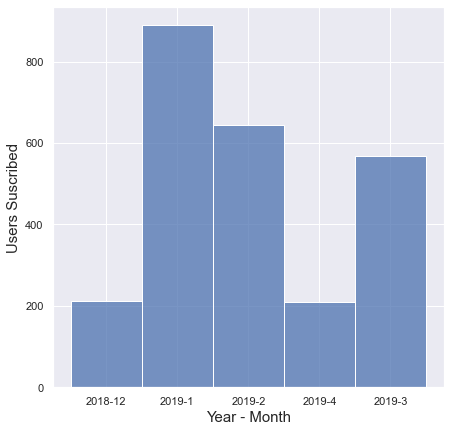

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

dist, ax = plt.subplots(figsize = (7,7))
ax = sns.histplot(df_suscribed, x='month_year')
ax.set_ylabel('Users Suscribed', fontsize = 15)
ax.set_xlabel('Year - Month', fontsize = 15)

## 7. Favorite book category

In [20]:
runQuery("""
    WITH books(book_id, category_1) AS (
        SELECT a.id
            , bc.name
            --, a.book_category_codes[2]
            --, a.book_category_codes[3]	
        FROM audiobook a
        INNER JOIN book_categories bc
        ON a.book_category_codes[1]=bc.book_cateogory_code
    ),
    users_suscribed AS (
        SELECT id
        FROM users
        WHERE has_been_subscribed
    )
    SELECT SUM(seconds),
        category_1
    FROM audiobook_plays a
    INNER JOIN books b
    ON a.audiobook_id = b.book_id
    INNER JOIN users_suscribed us
    ON a.user_id = us.id 
    GROUP BY category_1
    ORDER BY SUM(seconds) DESC
    LIMIT 10;
""")

,sum,category_1
0,6582429.746,Fiction / Romance / Contemporary
1,5047744.469,Fiction / Romance / General
2,4734604.922,Biography & Autobiography / Personal Memoirs
3,4574433.808,Juvenile Nonfiction / Drama
4,4269310.992,Fiction / General
5,3398332.484,Fiction / Literary
6,3271884.962,Business & Economics / Personal Finance / General
7,2306771.739,History / General
8,2150941.815,Juvenile Fiction / General
9,2043746.256,Juvenile Fiction / Love & Romance
